# Message SPAM Classifier

## Load Libs:

In [2]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding , LSTM , Dropout , Dense
import matplotlib.pyplot as plt

import tkinter as tk
from tkinter import messagebox


## Load Data:

In [3]:
def load_data(path):
    text,label=[],[];
    with open(path) as file:
        for line in file:
            tokens= line.split()
            label.append(tokens[0])
            text.append(' '.join(tokens[1:]))
    return [text,label]

## Mapping:

In [4]:
X,Y=load_data('Message Classifier\\data') 
word2int={'ham':0,'spam':1}
int2word={0:'ham',1:'spam'}

In [10]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(X)

X_digit=tokenizer.texts_to_sequences(X)

X_digit=np.array(X_digit,dtype=object)
Y=np.array(Y)

sen_length=100

X_digit=pad_sequences(X_digit,maxlen=sen_length,)#padding='pos ' 

#tokenizer.word_index
#Y = [word2int[y] for y in Y]
#Y = to_categorical(Y)

## Split and Shuffle:

In [11]:

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X_digit,Y,test_size=0.25, random_state=7)

print('Xtrain : ',Xtrain.shape)
print('Xtest : ',Xtest.shape)
print('Ytrain : ',Ytrain.shape)
print('Ytest : ',Ytest.shape)

Xtrain :  (4180, 100)
Xtest :  (1394, 100)
Ytrain :  (4180, 2)
Ytest :  (1394, 2)


## Generate Embedding:

In [12]:
def generate_Embedding(tokenizer,dim):
    embedding={}
    with open(f"Message Classifier\\glove.6B\\glove.6B.{dim}d.txt",encoding='utf8') as file:

        for line in tqdm.tqdm(file, "Reading the GloVe file"):
            tokens = line.split()
            word = tokens[0]
            vector = np.array(tokens[1:],dtype='float32')
            embedding[word] = vector

    wordI = tokenizer.word_index
    embedding_matrix = np.zeros((len(wordI)+1,dim))

    for word, indx in wordI.items():
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[indx]= vector
            
    return embedding_matrix

In [13]:
embedding_matrix= generate_Embedding(tokenizer,100)

Reading the GloVe file: 400000it [00:07, 53286.19it/s]


In [14]:
embedding_matrix[tokenizer.word_index.get('tunis')]

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
         -0.032502  ,  0.80620003],
        [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
          0.47646999, -0.15983   ],
        ...,
        [-0.12201   ,  0.20465   ,  0.53192002, ..., -0.164     ,
         -0.41637   ,  0.66426003],
        [-0.41600999,  0.16974001,  0.43457001, ..., -0.083432  ,
          0.49520999,  0.77258003],
        [ 0.46118999,  0.3567    ,  0.026078  , ..., -0.0056525 ,
          0.55176002,  0.77563   ]]])

## Build LSTM model:

In [17]:
#LONG SHORT TERM MEMORY

def build_model(embedding_matrix, lstm_untis):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                       weights= [embedding_matrix],
                       trainable=False,
                       input_length=sen_length ))

    model.add(LSTM(lstm_untis,recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(2,activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()

    return model

In [18]:
model=build_model(embedding_matrix, 128)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │         901,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 901,300 (3.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 901,300 (3.44 MB)

### Train the model:

In [19]:
history =model.fit(Xtrain,Ytrain,validation_data=(Xtest,Ytest),batch_size=64,epochs=10,verbose=1)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8752 - loss: 0.3027 - val_accuracy: 0.9562 - val_loss: 0.1185
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9697 - loss: 0.0914 - val_accuracy: 0.9677 - val_loss: 0.0910
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9777 - loss: 0.0724 - val_accuracy: 0.9749 - val_loss: 0.0724
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9845 - loss: 0.0602 - val_accuracy: 0.9785 - val_loss: 0.0694
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9865 - loss: 0.0441 - val_accuracy: 0.9792 - val_loss: 0.0696
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9850 - loss: 0.0394 - val_accuracy: 0.9641 - val_loss: 0.1015
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9850 - loss: 0.0444 - val_accuracy: 0.9727 - val_loss: 0.0848
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9911 - loss: 0.0389 - val_accuracy: 0.9785 - v

## Report the results:

In [20]:
report=history.history
report.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

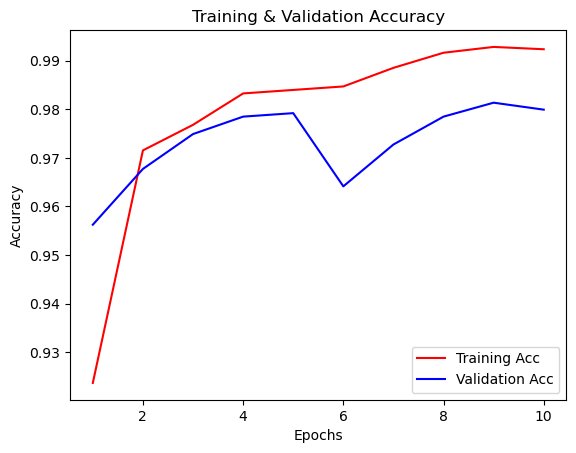

In [21]:
acc = report['accuracy']
val_acc = report['val_accuracy']
epochs =range(1,11)

plt.plot(epochs , acc,'r' ,label="Training Acc");
plt.plot(epochs , val_acc,'b' ,label="Validation Acc");
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs");
plt.ylabel("Accuracy");
plt.legend(loc='lower right')

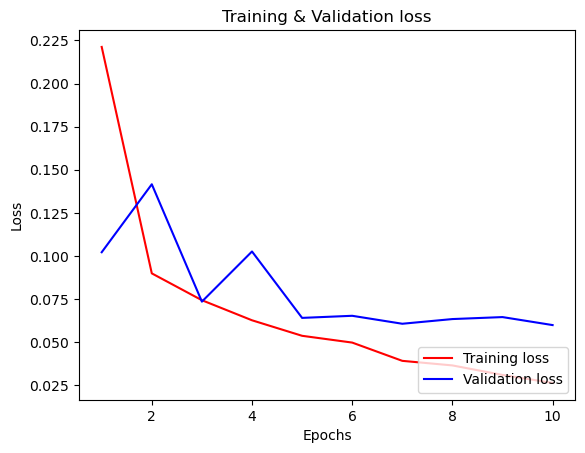

In [15]:
loss = report['loss']
val_loss = report['val_loss']
epochs =range(1,11)

plt.plot(epochs , loss,'r' ,label="Training loss");
plt.plot(epochs , val_loss,'b' ,label="Validation loss");
plt.title("Training & Validation loss")
plt.xlabel("Epochs");
plt.ylabel("Loss");
plt.legend(loc='lower right')

In [22]:
# results 

results = model.evaluate(Xtest,Ytest)

print(f'Accuracy : {results[1]*100:.2f}%')

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9831 - loss: 0.0576
Accuracy : 97.99%


## TESTING:

In [23]:
def prediction(model,sms):
    seq=tokenizer.texts_to_sequences([sms])
    seq=pad_sequences(seq,maxlen=sen_length)

    predict=model.predict(seq)[0]
    return int2word[np.argmax(predict)]

In [24]:
prediction(model,"Even my brother is not like to speak with me. They treat me like aids patent")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


'ham'

## Saving the Classifier (.h5 or .KERAS files)

In [25]:
model.save('msg_classifier_model.h5')

In [ ]:
def classify_text():
    text = text_entry.get("1.0", tk.END).strip()
    if text:
        result = prediction(model, text)
        result_label.config(text=f"Prediction: {result}")
    else:
        messagebox.showwarning("Input Error", "Please enter some text to classify.")

# Initialize the main window
root = tk.Tk()
root.title("Message Classifier")

# Create a text entry widget
text_entry = tk.Text(root, height=10, width=50)
text_entry.pack(pady=10)

# Create a button to classify the text
classify_button = tk.Button(root, text="Classify", command=classify_text)
classify_button.pack(pady=5)

# Create a label to display the result
result_label = tk.Label(root, text="Prediction: ")
result_label.pack(pady=5)

# Run the main loop
root.mainloop()